# Skin Segmentation Logistic Regression Notebook

## Problem Statement

## Loading & Cleaning Our Data

In [64]:
# Importing the Pandas library w/the alias "pd" for easier coding.
# Setting the URL variable equal to the URL at which my dataset is located.
# Reading the dataset into a variable called df with the use of Pandas, thereby creating a dataframe out of it.
# Inspecting the first five rows of df.

import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'

df = pd.read_csv(url, sep = '\s+', header=None) # using whitespace as my separator

df.head()

,0,1,2,3
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


- Below, we rename the columns to what they should be.

In [65]:
df = df.rename(columns = {0:'B', 1: 'G', 2: 'R', 3: 'Skin or No-Skin'})
df.head()

,B,G,R,Skin or No-Skin
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


## Exploring Target Variable & Evaluating Class Balance

- Let's now let's dive a bit deeper into our target variable (or "outcome variable"), i.e. the last column of our dataframe.

In [66]:
print(df['Skin or No-Skin'].value_counts())
print(df['Skin or No-Skin'].value_counts(normalize=True))

2    194198
1     50859
Name: Skin or No-Skin, dtype: int64
2    0.792461
1    0.207539
Name: Skin or No-Skin, dtype: float64


- From the value_counts() readout above, you can see that our outcome variable is binary (meaning that it contains 1s and 2s). 
- From our dataset's description ([here](https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation)), we know that the skin samples total 50,859 in number, while the no-skin samples total 194,198. So, here **1s are skin-pixels and 2 are no-skin pixels.**
- We can see in the normalized readout (the 2nd one, showing the percentages of the total that each label makes up) that our dataset is pretty imbalanced: about 79% of our pixels are classified as no-skin while only about 21% of our pixels are classified as skin. While this might seem imbalanced, in data-science circles this type of imbalance is perfectly acceptable; if we had a split along the lines of 99% v 1%, then we might consider using methods like SMOTE to balance our data out. (For more on SMOTE, I recommend checking out Nick Becker states in his blog post "[The Right Way to Oversample](https://beckernick.github.io/oversampling-modeling/))

## Preparing Data for Modeling

In [67]:
# assigning our target variable to "y"

y = df['Skin or No-Skin']

In [68]:
# creating a dataframe for our x-variables, making sure to drop null values

X = df.iloc[:,:-1].dropna()
X.head()

,B,G,R
0,74,85,123
1,73,84,122
2,72,83,121
3,70,81,119
4,70,81,119


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1142a0898>,
      dtype=object)

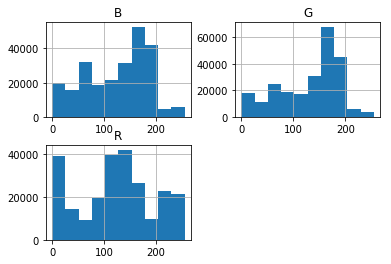

In [69]:
# Let's quickly inspect the distributions of our independent variables
# Since we're doing logit regression, we don't need to normalize or scale them, but it's nice to explore their distributions

X.hist()

- To run machine learning models of any kind, you always need to split your data into a training set and a test set. You will use your training set to train your model, and then test out how well your model is classifying values on your test data.
- Here, we use sklearn's train_test_split function to get an 80/20 split between our train/test data for our X and y values.
- (After this step is when we will balance our target variable.)

In [104]:
# split my data into test and train datasets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)


## Modeling with SciKit Learn

- While you could run a logistic regression model manually, it's much easier to use sklearn's built-in Logistic Regression class.
- Here, we are instantiating a Logistic Regression object (without an intercept just to keep things easy, and a C parameter of something super, super small in order to reduce overfitting) called logreg (see [here](https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul) for more info on C-parameters)
- We then fit our model to our training data and assign it a variable named model_log


In [131]:
# Instantiating estimator
logreg = LogisticRegression(fit_intercept = False, C = 1e12)

# Creating logit reg model, fitting to training data
model_log = logreg.fit(X_train, y_train)

# Making predictions using training data & test data
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

from sklearn.metrics import *

print ('TRAINING RESULTS')
print (f'Accuracy Score: {round(model_log.score(X_train, y_train),2)}')
print (f'Recall: {round(recall_score(y_train, y_hat_train),2)}')
print (f'F-1 Score: {round(f1_score(y_train, y_hat_train),2)}')
print (f'R-Squared: {round(r2_score(y_train, y_hat_train),2)}')
print (f'Precision: {round(precision_score(y_train, y_hat_train),2)}')
print (f'Recall: {round(recall_score(y_train, y_hat_train),2)}')
print (f'MSE: {round(mean_squared_error(y_train, y_hat_train),2)}')

print ('\nTEST RESULTS')
print (f'Accuracy Score: {round(model_log.score(X_test, y_test),2)}')
print (f'Recall: {round(recall_score(y_test, y_hat_test),2)}')
print (f'F-1 Score: {round(f1_score(y_test, y_hat_test),2)}')
print (f'R-Squared: {round(r2_score(y_test, y_hat_test),2)}')
print (f'Precision: {round(precision_score(y_test, y_hat_test),2)}')
print (f'Recall: {round(recall_score(y_test, y_hat_test),2)}')
print (f'MSE: {round(mean_squared_error(y_test, y_hat_test),2)}')



/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TRAINING RESULTS
Accuracy Score: 0.91
Recall: 0.84
F-1 Score: 0.79
R-Squared: 0.43
Precision: 0.74
Recall: 0.84
MSE: 0.09

TEST RESULTS
Accuracy Score: 0.91
Recall: 0.84
F-1 Score: 0.79
R-Squared: 0.43
Precision: 0.74
Recall: 0.84
MSE: 0.09


## Evaluating Model Performance Using K-Fold Cross-Validation

In [136]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# instantiating my model
logreg = LogisticRegression(fit_intercept = False, C = 1e12)

# computing cv score (don't run train_test_split beforehand)
scores = cross_val_score(logreg, X, y, cv = 3)

# f-1 score
scores_f1 = cross_val_score(logreg, X, y, cv = 3, scoring='f1')

# r-squared
scores_r2 = cross_val_score(logreg, X, y, cv = 3, scoring='r2')

# precision
scores_precis = cross_val_score(logreg, X, y, cv = 3, scoring='precision')

# recall
scores_recall = cross_val_score(logreg, X, y, cv = 3, scoring='recall')

# negative MSE
scores_negMSE = cross_val_score(logreg, X, y, cv = 3, scoring='neg_mean_squared_error')


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarn

In [135]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [137]:
# The mean score and the 95% confidence interval of the score estimate
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("F-1 Score: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

print("R-Squared: %0.2f (+/- %0.2f)" % (scores_r2.mean(), scores_r2.std() * 2))

print("Precision: %0.2f (+/- %0.2f)" % (scores_precis.mean(), scores_precis.std() * 2))

print("Recall: %0.2f (+/- %0.2f)" % (scores_recall.mean(), scores_recall.std() * 2))

print("Negative MSE: %0.2f (+/- %0.2f)" % (scores_negMSE.mean(), scores_negMSE.std() * 2))


Accuracy: 0.90 (+/- 0.05)
F-1 Score: 0.77 (+/- 0.10)
R-Squared: 0.39 (+/- 0.33)
Precision: 0.74 (+/- 0.17)
Recall: 0.83 (+/- 0.09)
Negative MSE: -0.10 (+/- 0.05)


## More Evaluating

Confusion matrix, without normalization
[[10712  3759]
 [ 2021 44773]]


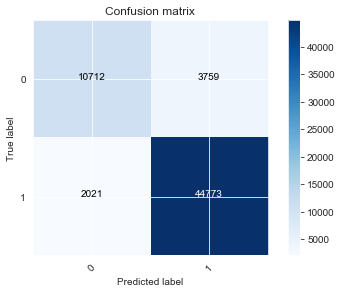

In [144]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

# here, 0s = no-skin ; 1s = skin
# You can see here that our model returned 10,712 true negatives ; 3,759 false positives;
# 2,021 false negatives, and 44,773 true positives


- A confusion matrix can tell us a lot that we can use to evaluate our model.
- Common evaluation metrics are precision, recall, accuracy, and f-1 score
- Let's calculate all four below.

In [145]:
# precision = tp / (tp + fp) # out of all our classifications, how many did we predict correctly true or false?
# recall = tp / (tp + fn) # out of all positive classifications, how many did we predict correctly?
# f-1 score = (2)(recall * precision) / (recall + precision)
# accuracy = (tp + tn) / total # observations

recall = 44773 / (44773 + 3759) # 96% 

precision = 44773 / (44773 + 2021) # 92% 

f1_score = 2* (recall * precision) / (recall + precision) # 94%

accuracy = (44773 + 10712) / (10712 + 3759 + 2021 + 44773) # 91%

# our accuracy score here is pretty interesting. As you can see, it's the same as our accuracy score on our test data
# that we got when we took the difference of the residuals between our actual y value and our predicted y-values
# this confirms our confusion matrix way of evaluating our model works!

- Even though it's interesting to do the above by hand, we can also use sklearn's classification_report function to see our precision, recall, and f1-score, as we do below.
- You can see that our calculations above match the sklearn's calculations for the 1s (the skins classifications, which is what we primarily care about)

In [146]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_hat_test))


              precision    recall  f1-score   support

           0       0.74      0.84      0.79     12733
           1       0.96      0.92      0.94     48532

   micro avg       0.91      0.91      0.91     61265
   macro avg       0.85      0.88      0.86     61265
weighted avg       0.91      0.91      0.91     61265



- Now this all seems great, our evaluation metrics are high! However, these metrics can be misleading because we don't know whether or not our dataset is *skewed*
- Skewed datasets can seem great when simply looking at precision, recall, etc.
- For example, if you have a skewed dataset with rare events (such as a disease or winning the lottery) where there is only 2 positive cases in 1000, then even a trivial algorithm that classifies everything as 'not a member' will achieve an accuracy of 99.8% (998 out of 1000 times it was correct). So, that accuracy number will need more context to actually be evaluated as "good" or "bad." 
- This is where ROC-AUC curves come in! We can use these as an alternative means to measure how well our model is performing.
- ROC curves are a helpful metric to look at because they measure the true positive rate against the false positive rate.

In [147]:
from sklearn.metrics import roc_curve, auc

# creating ROC curve of our train data
y_score_train = logreg.fit(X_train, y_train).decision_function(X_train)

# fpr stands for false positive rate, and tpr stands for true positive rate.
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_score_train)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.9337460478211796


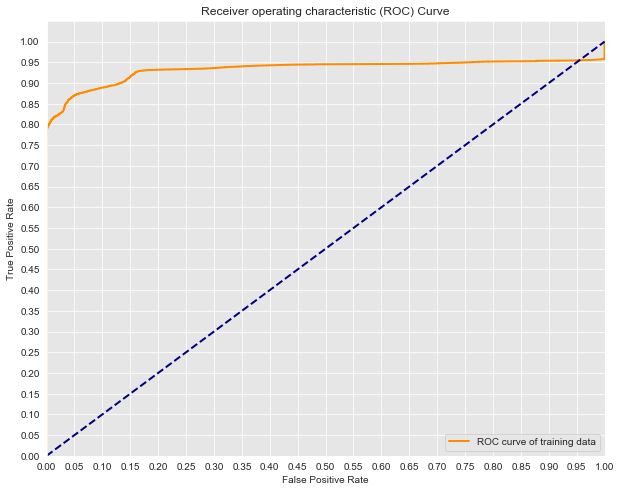

In [148]:
# Graphing ROC curve of train data

import matplotlib.pyplot as plt
import seaborn as sns


#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# printing AUC info
print('AUC: {}'.format(auc(fpr_train, tpr_train)))

# plotting the tpr and fpr
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='ROC curve of training data')

# aesthetics
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# AUC is 934

In [149]:
# creating ROC curve of our test data
y_score_test = logreg.fit(X_train, y_train).decision_function(X_test)

# fpr stands for false positive rate, and tpr stands for true positive rate.
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_score_test)

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.9324586452933378


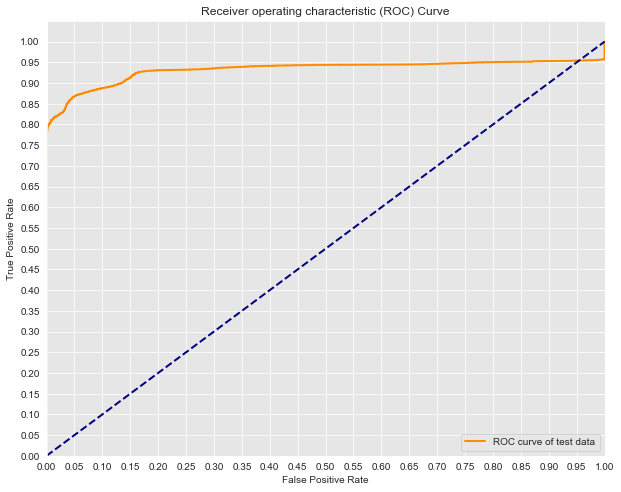

In [150]:
# Graphing ROC curve of test data

import matplotlib.pyplot as plt
import seaborn as sns


#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# printing AUC info
print('AUC: {}'.format(auc(fpr_test, tpr_test)))

# plotting the tpr and fpr
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve of test data')

# aesthetics
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# AUC is 932 slightly lowert than our training set.

- You can see above that both our ROC curves hug the top left of the ROC-AUC graph, which is pretty great.
- Our training ROC curve has an AUC of 93.4%, while our test ROC curve has an AUC of 93.2%.
- Let's see how balanced or imbalanced our dataset is.

In [157]:
# smote

print(classification_report(y_test_smote,y_hat_test_smote))

print(classification_report(y_train_smote,y_hat_train_smote))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88     48547
           1       0.85      0.92      0.89     48552

   micro avg       0.88      0.88      0.88     97099
   macro avg       0.88      0.88      0.88     97099
weighted avg       0.88      0.88      0.88     97099

              precision    recall  f1-score   support

           0       0.92      0.84      0.88    145651
           1       0.85      0.92      0.89    145646

   micro avg       0.88      0.88      0.88    291297
   macro avg       0.88      0.88      0.88    291297
weighted avg       0.88      0.88      0.88    291297



- So interesting! As we can see, our model performed worse after we balanced its weights.
- Our original model (with the class imbalance and all) was our best model! 

In [158]:
# original

print(classification_report(y_test,y_hat_test))

print(classification_report(y_train,y_hat_train))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79     12733
           1       0.96      0.92      0.94     48532

   micro avg       0.91      0.91      0.91     61265
   macro avg       0.85      0.88      0.86     61265
weighted avg       0.91      0.91      0.91     61265

              precision    recall  f1-score   support

           0       0.74      0.84      0.79     38126
           1       0.96      0.92      0.94    145666

   micro avg       0.91      0.91      0.91    183792
   macro avg       0.85      0.88      0.86    183792
weighted avg       0.91      0.91      0.91    183792



## So what does this all mean? How can we interpret these results?
- Well, we can say that our original model was our best performer, and that our classification algorithm is correct in predicted an image as having skin in it (the 1s) 94% of the time (using f1 score here)
- While this might sound like a good classification rate, there are myriad ethical issues that come with creating algorithms used for facial recognition. What if our model was going to be used to identify wanted terrorists in a crowd? This is certainly different than recognizing a face for a filter in Snapchat.
- If our model were to be used for Snapchat filters, we'd likely want to optimize towards upping our recall score - it's ostensibly better that we mistakenly identify things as faces when they're not faces than only recognize real faces some of the time. 
- On the other hand, if our model were to be used for spotting wanted criminals in a crowd, we'd likely still want to optimize towards recall, but the consequences would be vastly different. Is it worth bringing innocent people in for questioning and potentially violating their rights if it meant that you'd catch wanted criminals almost 100% of the time? Perhaps not.